## Part One: Classifying Review Sentiment with Bag-of-Words Features

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots
sns.set_style('white')

In [27]:
x_train_raw = pd.read_csv('data/data_reviews/x_train.csv')
y_train_raw = pd.read_csv('data/data_reviews/y_train.csv')
x_test_raw = pd.read_csv('data/data_reviews/x_test.csv')

In [28]:
x_train_raw.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


In [30]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val = train_test_split(x_train_raw['text'].values, y_train_raw['is_positive_sentiment'].values, test_size=0.2, random_state=0)
print(len(x_tr),len(y_tr),len(x_val),len(y_val))

1920 1920 480 480


In [32]:
x_test_raw['website_name'].value_counts()

imdb      200
yelp      200
amazon    200
Name: website_name, dtype: int64

In [33]:
reviews = x_train_raw['text'].values
print('Number of Reviews:',len(reviews))

Number of Reviews: 2400


In [34]:
# Simplest basic tokenizing and counting:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
x = count_vectorizer.fit_transform(reviews)
print('Number of Words/Features:',x.toarray().shape[1])

Number of Words/Features: 4510


In [ ]:
print(count_vectorizer.get_feature_names())

In [95]:
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import string

def remove_punctuation(text):
    s = text.translate(str.maketrans('', '', string.punctuation))
    removed_numbers = re.sub("\S*\d\S*", "", s).strip()
    return removed_numbers

def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed

def text_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
    return lemmatized_output

from spellchecker import SpellChecker

spell = SpellChecker()

def xstr(s):
    return ['' if v is None else v for v in s]

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    # print(corrected_text)
    return " ".join(xstr(corrected_text))
        
def make_lowercase(text):
    lowered_output = ' '.join([w.lower() for w in text.split()])
    return lowered_output

def remove_proper_nouns(text):
    tagged_sentence = nltk.tag.pos_tag(text.split())
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS' and tag!= 'PRON']
    edited_text = ' '.join(w for w in edited_sentence)
    return edited_text

def expand_contractions(text):
    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)
    return text

stop_words = stopwords.words('english')
def remove_stopwords(text):
    edited_text = ' '.join(w for w in text.split() if w not in stop_words)
    return edited_text

def clean_reviews_fn(reviews):
#     reviews = x_train_raw['text'].values
    clean_reviews = []
    for r in reviews:
        lowercase_review = make_lowercase(r)
        expand_review = expand_contractions(lowercase_review)
        remove_punc = remove_punctuation(expand_review)
        remove_stop = remove_stopwords(remove_punc)
        # nouns_removed_review = remove_proper_nouns(removed_numbers)
        lemmatize_review = text_lemmatization(remove_stop)
        # stemming_review = text_stemming(remove_stop)
        spell_review = correct_spellings(lemmatize_review)
        clean_reviews.append(spell_review)
    
    return clean_reviews

In [96]:
remove_stopwords('and a the cat bag')

'cat bag'

In [97]:
from contractions import contractions

In [98]:
x_train_cleaned = clean_reviews_fn(x_train_raw['text'].values)
x_test_cleaned = clean_reviews_fn(x_test_raw['text'].values)

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [100]:
from sklearn.linear_model import LogisticRegression

def simple_logistic_classify(X_tr, y_tr,description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_tr, y_tr)
    print('Test Score with', description, 'features', score)
    return model

In [101]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.model_selection import GridSearchCV

In [81]:
count_vectorizer = CountVectorizer(stop_words=stop_words,ngram_range=(1,2),min_df=2)
x = count_vectorizer.fit_transform(x_train_cleaned)
X_tr = pd.DataFrame(x.toarray(), columns=count_vectorizer.get_feature_names())
print('Number of Words/Features:',x.toarray().shape[1])

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_tr, y_train_raw)
# report performance
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Number of Words/Features: 2176
Best: 0.797917 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.765417 (0.020246) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.765833 (0.020310) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.765417 (0.020246) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.794583 (0.017780) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794583 (0.017780) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794583 (0.017780) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.797917 (0.018470) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.797500 (0.017892) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.797917 (0.018470) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.787917 (0.021526) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.787917 (0.021526) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.787917 (0.019583) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'libl

In [102]:

# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
count_vectorizer = CountVectorizer(stop_words=stop_words,ngram_range=(1,2),min_df=2)
x = count_vectorizer.fit_transform(x_train_cleaned)
X_tr = pd.DataFrame(x.toarray(), columns=count_vectorizer.get_feature_names())
print('Number of Words/Features:',x.toarray().shape[1])

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = 'l2'
# c_values = [100, 10, 1.0, 0.1, 0.01]
alpha_vals = np.logspace(-2, 2, base=10, num=50)
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model

scores_list  = []
for c in alpha_vals:
    model = LogisticRegression(penalty=penalty,C=c)
    scores = cross_val_score(model, X_tr, y_train_raw, scoring='accuracy', cv=cv, n_jobs=-1)
    scores_list.append(mean(scores))

Number of Words/Features: 2294


In [103]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline

count_vectorizer = CountVectorizer(stop_words=stop_words,ngram_range=(1,2),min_df=2)
x = count_vectorizer.fit_transform(x_train_cleaned)
X_tr = pd.DataFrame(x.toarray(), columns=count_vectorizer.get_feature_names())
print('Number of Words/Features:',x.toarray().shape[1])

pipeline = make_pipeline(LogisticRegression())

cv = KFold(n_splits=10, random_state=1, shuffle=True)
kfold = cv.split(X_tr, y_train_raw)
scores = []
tr_scores = []
for k, (train, test) in enumerate(kfold):
    pipeline.fit(X_tr.iloc[train, :], y_train_raw.iloc[train])
    tr_score = pipeline.score(X_tr.iloc[train, :], y_train_raw.iloc[train])
    score = pipeline.score(X_tr.iloc[test, :], y_train_raw.iloc[test])
    scores.append(score)
    tr_scores.append(tr_score)
    print('Fold: %2d, Training/Test Split Distribution: %s, Train Accuracy: %.3f,Test Accuracy: %.3f' % (k+1, np.bincount(y_train_raw['is_positive_sentiment'].iloc[train]), tr_score,score))
 
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Number of Words/Features: 2294
Fold:  1, Training/Test Split Distribution: [1080 1080], Train Accuracy: 0.954,Test Accuracy: 0.787
Fold:  2, Training/Test Split Distribution: [1091 1069], Train Accuracy: 0.952,Test Accuracy: 0.833
Fold:  3, Training/Test Split Distribution: [1078 1082], Train Accuracy: 0.953,Test Accuracy: 0.779
Fold:  4, Training/Test Split Distribution: [1086 1074], Train Accuracy: 0.951,Test Accuracy: 0.787
Fold:  5, Training/Test Split Distribution: [1085 1075], Train Accuracy: 0.950,Test Accuracy: 0.821
Fold:  6, Training/Test Split Distribution: [1075 1085], Train Accuracy: 0.954,Test Accuracy: 0.838
Fold:  7, Training/Test Split Distribution: [1084 1076], Train Accuracy: 0.954,Test Accuracy: 0.787
Fold:  8, Training/Test Split Distribution: [1070 1090], Train Accuracy: 0.953,Test Accuracy: 0.804
Fold:  9, Training/Test Split Distribution: [1068 1092], Train Accuracy: 0.954,Test Accuracy: 0.783
Fold: 10, Training/Test Split Distribution: [1083 1077], Train Accura

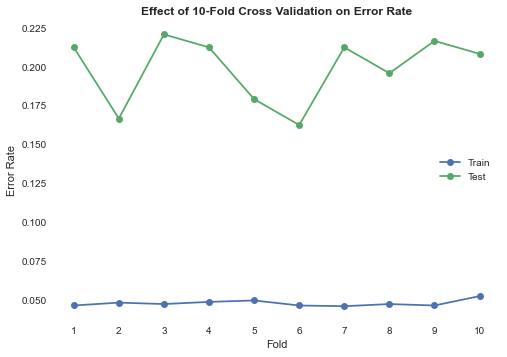

In [106]:
fig = plt.figure()
ax = plt.axes()
ax.plot(list(range(1,11)), [1-x for x in tr_scores],label='Train',marker='o')
ax.plot(list(range(1,11)), [1-x for x in scores],label='Test',marker='o')
# ax.plot(alpha_vals, test_error_avg, label='Test')
# ax.set_xscale('log')
ax.set_xticks(list(range(1,11)))
ax.set_title('Effect of 10-Fold Cross Validation on Error Rate', fontweight ="bold")
ax.set_xlabel('Fold')
ax.set_ylabel('Error Rate')
# ax.grid(which='major')
ax.legend(loc='center right')

In [107]:
print('10-Fold Cross Validation')
print('Average Training Error Rate: %.3f'%mean( [1-x for x in tr_scores]))
print('Average Testing Error Rate: %.3f'%mean([1-x for x in scores]))

10-Fold Cross Validation
Average Training Error Rate: 0.048
Average Testing Error Rate: 0.199


In [108]:
reg_tr_acc = []
reg_te_acc = []
alpha_vals = np.logspace(-2, 2, base=10, num=50)
for c in alpha_vals:
    pipeline = make_pipeline(LogisticRegression(C=c))
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    kfold = cv.split(X_tr, y_train_raw)
    scores = []
    tr_scores = []
    for k, (train, test) in enumerate(kfold):
        pipeline.fit(X_tr.iloc[train, :], y_train_raw.iloc[train])
        tr_score = pipeline.score(X_tr.iloc[train, :], y_train_raw.iloc[train])
        score = pipeline.score(X_tr.iloc[test, :], y_train_raw.iloc[test])
        scores.append(score)
        tr_scores.append(tr_score)
        # print('Fold: %2d, Training/Test Split Distribution: %s, Train Accuracy: %.3f,Test Accuracy: %.3f' % (k+1, np.bincount(y_train_raw['is_positive_sentiment'].iloc[train]), tr_score,score))
    reg_tr_acc.append(np.mean(tr_scores))
    reg_te_acc.append(np.mean(scores))
    
    # print('\n\nAlpha %.3f Cross-Validation accuracy: %.3f +/- %.3f' %(c,np.mean(scores), np.std(scores)))

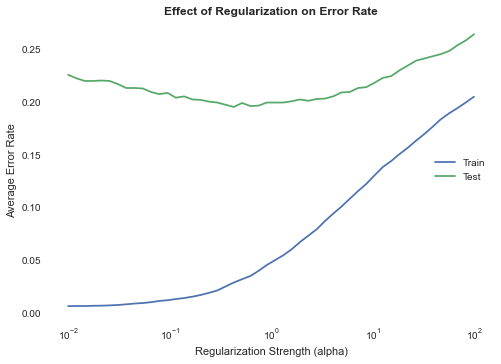

In [110]:
fig = plt.figure()
ax = plt.axes()
ax.plot(1/alpha_vals, [1-x for x in reg_tr_acc],label='Train')
ax.plot(1/alpha_vals, [1-x for x in reg_te_acc], label='Test')
ax.set_xscale('log')
ax.set_title('Effect of Regularization on Error Rate', fontweight ="bold")
ax.set_xlabel('Regularization Strength (alpha)')
ax.set_ylabel('Average Error Rate')
ax.legend(loc='right')

In [126]:
solvers = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']
sol_tr_acc = []
sol_te_acc = []
for s in solvers:
    model = LogisticRegression(solver=s)
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    kfold = cv.split(X_tr, y_train_raw)
    scores = []
    tr_scores = []
    for k, (train, test) in enumerate(kfold):
        model.fit(X_tr.iloc[train, :], y_train_raw.iloc[train])
        tr_score = model.score(X_tr.iloc[train, :], y_train_raw.iloc[train])
        score = model.score(X_tr.iloc[test, :], y_train_raw.iloc[test])
        scores.append(score)
        tr_scores.append(tr_score)
        # print('Fold: %2d, Training/Test Split Distribution: %s, Train Accuracy: %.3f,Test Accuracy: %.3f' % (k+1, np.bincount(y_train_raw['is_positive_sentiment'].iloc[train]), tr_score,score))
    sol_tr_acc.append(np.mean(tr_scores))
    sol_te_acc.append(np.mean(scores))
    

In [124]:
count_vectorizer = CountVectorizer(stop_words=stop_words,ngram_range=(1,2),min_df=2)
x = count_vectorizer.fit_transform(x_train_cleaned)
X_tr = pd.DataFrame(x.toarray(), columns=count_vectorizer.get_feature_names())
print('Number of Words/Features:',x.toarray().shape[1])

solvers = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_tr, y_train_raw)
# report performance
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Number of Words/Features: 2294
Best: 0.801250 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.774583 (0.015304) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.774583 (0.015751) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.774583 (0.015304) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.791667 (0.009317) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.791667 (0.009317) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.791667 (0.009317) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.801250 (0.020502) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.801250 (0.020502) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.801250 (0.020502) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.782500 (0.010000) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.782917 (0.009939) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.783333 (0.011180) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'libl

In [131]:
# fig = plt.figure()
# ax = plt.axes()
# ax.scatter([0,1,2],[1-x for x in sol_tr_acc],label='Train',marker='v')
# ax.scatter([0,1,2],[1-x for x in sol_te_acc], label='Test',marker='v')
# ax.set_title('Solver vs Error Rate', fontweight ="bold")
# ax.set_xlabel('Solver')
# ax.set_ylabel('Average Error Rate')
# ax.legend(loc='right')

d = {'Solver':solvers,'Train Error Rate':["%.2f%%"%(100-x*100) for x in sol_tr_acc],'Test Error Rate':["%.2f%%"%(100-x*100) for x in sol_te_acc]}
df = pd.DataFrame(d)
df.set_index('Solver', inplace=True)
df.head()

,Train Error Rate,Test Error Rate
Solver,,
newton-cg,4.78%,19.88%
lbfgs,4.78%,19.88%
liblinear,4.76%,19.88%
sag,4.78%,19.92%
saga,4.78%,19.92%


In [211]:
clean_reviews = clean_reviews_fn(x_train_raw['text'].values)
stop_words = stopwords.words('english')




model = simple_logistic_classify(X,y_train_raw,'Logistic regression')

clean_test_reviews = clean_reviews_fn(x_test_raw['text'].values)
x_test = count_vectorizer.transform(clean_test_reviews)
X_test = pd.DataFrame(x_test.toarray(), columns=count_vectorizer.get_feature_names())
yproba1_test = model.predict_proba(X_test)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)

Number of Words/Features: 1472


C:\Users\Priyanshi_code\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Priyanshi_code\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Score with Logistic regression features 0.9133333333333333


C:\Users\Priyanshi_code\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [219]:
type(yproba1_test)

numpy.ndarray

In [215]:
clean_reviews = clean_reviews_fn(x_train_raw['text'].values)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2),min_df=1)
x = tfidf_vectorizer.fit_transform(clean_reviews)
X = pd.DataFrame(x.toarray(), columns=tfidf_vectorizer.get_feature_names())
print('Number of Words/Features:',x.toarray().shape[1])
model = simple_logistic_classify(X,y_train_raw,'Logistic regression')

clean_test_reviews = clean_reviews_fn(x_test_raw['text'].values)
x_test = tfidf_vectorizer.transform(clean_test_reviews)
X_test = pd.DataFrame(x_test.toarray(), columns=tfidf_vectorizer.get_feature_names())
yproba1_test = model.predict_proba(X_test)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)

C:\Users\Priyanshi_code\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Priyanshi_code\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of Words/Features: 9485
Test Score with Logistic regression features 0.9520833333333333


C:\Users\Priyanshi_code\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [216]:
zipped = zip(X.columns.values,model.coef_.flatten())
for n,c in sorted(zipped, key=lambda x: x[1]):
    print(n,c)

bad -3.041016615671191
worst -1.9132042904580908
poor -1.9110471207421877
terrible -1.7999822649197708
horrible -1.472090169876679
stupid -1.4617180806050627
awful -1.441649379877956
disappointing -1.4121751759508525
doe -1.2678575319634076
disappointed -1.2196008546878225
slow -1.2145575954531393
doe work -1.1820998212750435
wa -1.1618038727318574
sucked -1.1430028719104541
suck -1.1177206638062287
waste -1.093836779168123
minute -1.0500677074595421
buy -1.0414132557319475
overpriced -1.0066653053495127
going -0.9771006992720562
big -0.9592128472269755
could -0.9535980344299474
even -0.9150646215155317
cost -0.9106333620629999
probably -0.8933312529070287
unfortunately -0.8826599631172802
would -0.8710499037217667
unreliable -0.8508375601786732
hear -0.850504291369981
useless -0.8419067394456413
weak -0.8308814726784152
return -0.8288676711762147
rude -0.8128351577301307
cheap -0.8118355845201923
eating -0.8058915756532824
disgusting -0.8032963612649617
real -0.8028763107762301
break 

In [133]:
model.coef_.flatten()

array([-0.05828826, -0.24512022,  0.31917701, ..., -0.74667662,
       -0.20323003, -0.14826124])